# LIMEを用いたRNNモデルの解釈

使うモデルは、埋め込み層が1つあるLSTMモデルです。基本的な前処理は、[DeepNN_Example.ipynb](https://github.com/practical-nlp/practical-nlp/blob/master/Ch4/DeepNN_Example.ipynb)と同じなので、詳細はそちらをご覧ください。
このノートブックでは、[LIME](https://github.com/marcotcr/lime)を用いて、ディープラーニングのモデルを解釈する方法を紹介します。

## 準備

### パッケージのインストール

In [1]:
!pip install lime==0.2.0.1

     |████████████████████████████████| 275 kB 5.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=59a6c7294c9ef1cd90ec5b680b5e213cd65b859df0ae19d67bbe783d574d7af3
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


### インポート

In [2]:
import os
import re
import string

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Embedding, LSTM, TextVectorization
from tensorflow.keras.models import Model, Sequential

### データセットの読み込み

In [3]:
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:80%]', 'train[80%:]', 'test'),
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete5XIFPU/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete5XIFPU/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete5XIFPU/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
# モデルの学習に関わるハイパーパラメータ
MAX_SEQUENCE_LENGTH = 250
MAX_NUM_WORDS = 20000 
EMBEDDING_DIM = 100
NUM_CLASSES = 2

## 前処理

In [5]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    cleaned_html = tf.strings.regex_replace(
        stripped_html,
        '[%s]' % re.escape(string.punctuation),
        ''
    )
    return cleaned_html

In [6]:
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=MAX_NUM_WORDS,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH
)

In [7]:
# adapt用にテキストだけのデータセットを作成
train_text = train_data.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_data.shuffle(len(train_data)).batch(32).prefetch(AUTOTUNE)
val_ds = validation_data.shuffle(len(validation_data)).batch(32).prefetch(AUTOTUNE)
test_ds = test_data.shuffle(len(test_data)).batch(32).prefetch(AUTOTUNE)

## モデルの学習

In [13]:
model = Sequential([
    vectorize_layer,
    Embedding(vectorize_layer.vocabulary_size(), EMBEDDING_DIM, mask_zero=True),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(128, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [14]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=2
)

Epoch 1/2
625/625 [==============================] - 521s 825ms/step - loss: 0.4870 - accuracy: 0.7681 - val_loss: 0.5793 - val_accuracy: 0.6964
Epoch 2/2
625/625 [==============================] - 518s 828ms/step - loss: 0.3104 - accuracy: 0.8769 - val_loss: 0.3902 - val_accuracy: 0.8300


## LIMEを用いたモデルの解釈

In [15]:
test_examples_batch, test_labels_batch = next(iter(test_data.batch(10)))
test_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.",
   

In [19]:
# We choose a sample from test set
idx = 1
text_sample = test_examples_batch[idx].numpy().decode('utf-8')
class_names = ['negative', 'positive']

print(text_sample)
print('Probability(positive) =', model.predict([text_sample])[0, 1])
print('True class: %s' % class_names[test_labels_batch[idx]])

A blackly comic tale of a down-trodden priest, Nazarin showcases the economy that Luis Bunuel was able to achieve in being able to tell a deeply humanist fable with a minimum of fuss. As an output from his Mexican era of film making, it was an invaluable talent to possess, with little money and extremely tight schedules. Nazarin, however, surpasses many of Bunuel's previous Mexican films in terms of the acting (Francisco Rabal is excellent), narrative and theme.<br /><br />The theme, interestingly, is something that was explored again in Viridiana, made three years later in Spain. It concerns the individual's struggle for humanity and altruism amongst a society that rejects any notion of virtue. Father Nazarin, however, is portrayed more sympathetically than Sister Viridiana. Whereas the latter seems to choose charity because she wishes to atone for her (perceived) sins, Nazarin's whole existence and reason for being seems to be to help others, whether they (or we) like it or not. The 

In [20]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=class_names)
explanation = explainer.explain_instance(text_sample, model.predict, num_features=10)

Text(0.5, 1.0, 'Sample 1 features weights given by LIME')

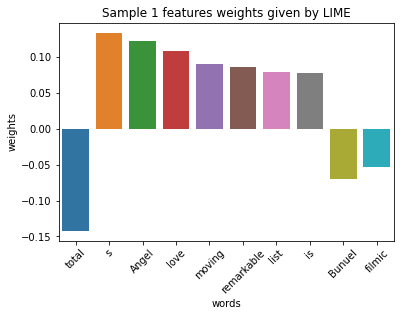

In [21]:
%matplotlib inline
from collections import OrderedDict

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

weights = OrderedDict(explanation.as_list())
lime_weights = pd.DataFrame({'words': list(weights.keys()), 'weights': list(weights.values())})

sns.barplot(x="words", y="weights", data=lime_weights)
plt.xticks(rotation=45)
plt.title(f"Sample {idx} features weights given by LIME")

LIMEを用いて、RNNに対する説明を与えてみました。上記のグラフを見ると、出力はポジティブであり、「love」や「remarkable」などの単語が影響を与えていることがわかります。

